In [50]:

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
from tqdm import tqdm
from torch_geometric.nn import Node2Vec
from itertools import permutations
import torch_cluster



OSError: libc10_cuda.so: cannot open shared object file: No such file or directory

In [2]:
# Transformation for the images
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = models.vgg16(pretrained=True).features.to(device)
#vgg16 = torch.nn.Sequential(*list(vgg16.children())[:-1])

/n/home02/rskeweszorrilla/miniconda/envs/weber_env_2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/home02/rskeweszorrilla/miniconda/envs/weber_env_2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:

# A function to extract features for a given image
def extract_features(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = vgg16(img_t)
    return features.cpu().numpy().flatten()



In [5]:

def extract_image_data(dataset_path, extract_features_fn = None, considered_eras = ['00', '01', '02', '03', '04', '05', '06'], early_stop= False):
    characters = {}
    edges = []
    edge_attr = []
    # Load and process each image
    t = 0
    for root, dirs, files in tqdm(os.walk(dataset_path)):
        for file in sorted(files):
            if file.endswith(".png") and file.split("_")[-1][:2] in considered_eras:
                char_class, era = os.path.basename(root), file.split("_")[-1][:2]
                if char_class not in characters:
                    characters[char_class] = []
                
                img_path = os.path.join(root, file)
                if extract_features_fn is not None:
                    features = extract_features_fn(img_path)
                    res = (t, features, era, img_path)
                else:
                    res = (t, None, era, img_path)

                characters[char_class].append(res)
                t+=1
        if t > 40 and early_stop:
            break
    return characters



In [6]:
dataset_path = "images_background"
data_images_dict = extract_image_data(dataset_path, extract_features_fn=extract_features, early_stop=True)

8it [00:11,  1.46s/it]


In [7]:
char_class_encoder = LabelEncoder()
char_class_id_map = char_class_encoder.fit(list(data_images_dict.keys()))


In [14]:
def generate_graph_data_from_dict(data_images_dict):
    edges = []
    X = []
    y = []
    for char_class, data in data_images_dict.items():
        node_ids = [data[i][0] for i in range(len(data))]
        pairs = list(permutations(node_ids, 2))
        edges += pairs # Add pairs to the edges within a character class
        features = [data[i][1] for i in range(len(data))]
        X += features # Append features
        eras = [data[i][2] for i in range(len(data))]
        #print(eras)
        y += eras
        #img_path = [data[i][3] for i in range(len(data))]
    E = torch.tensor(edges, dtype=torch.long).t().contiguous()
    X = torch.tensor(X, dtype=torch.float)
    y = torch.tensor([int(label) for label in labels], dtype=torch.long)  # Convert all labels
    # Create PyG Data object
    data = Data(x=X, edge_index=E, y=y)
    return data


In [33]:
if data.validate(raise_on_error=True):
    print("Data is valid")

Data is valid


In [45]:
print("The object Data is")
print(data.edge_index[0].shape)

The object Data is
torch.Size([192])


In [37]:
def load_graph_from_data(data, device = 'cpu'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'  # check if cuda is available to send the model and tensors to the GPU
    model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                    context_size=10, walks_per_node=10,
                    num_negative_samples=1, p=1, q=1, sparse=True).to(device)
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)  # data loader to speed the train 
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)  # initzialize the optimizer 
    return model, loader, optimizer

In [38]:
data = generate_graph_data_from_dict(data_images_dict)
load_graph_from_data(data)

['02', '03', '04', '05']
['01', '02', '03', '04', '05']
['01', '02', '03', '04', '05']
['01', '02', '03', '04', '05', '06']
['01', '02', '03', '04', '05']
['01', '02', '03', '04', '05', '06']
['01', '02', '03', '04', '05', '06']
['01', '02', '03', '04', '05', '06']
tensor([1, 2, 3, 4, 5, 6])


ImportError: 'Node2Vec' requires either the 'pyg-lib' or 'torch-cluster' package

In [48]:
data.num_nodes


43

[t-SNE] Computing 42 nearest neighbors...
[t-SNE] Indexed 43 samples in 0.001s...
[t-SNE] Computed neighbors for 43 samples in 0.119s...
[t-SNE] Computed conditional probabilities for sample 43 / 43
[t-SNE] Mean sigma: 8.813629
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.460461
[t-SNE] KL divergence after 300 iterations: 0.033091


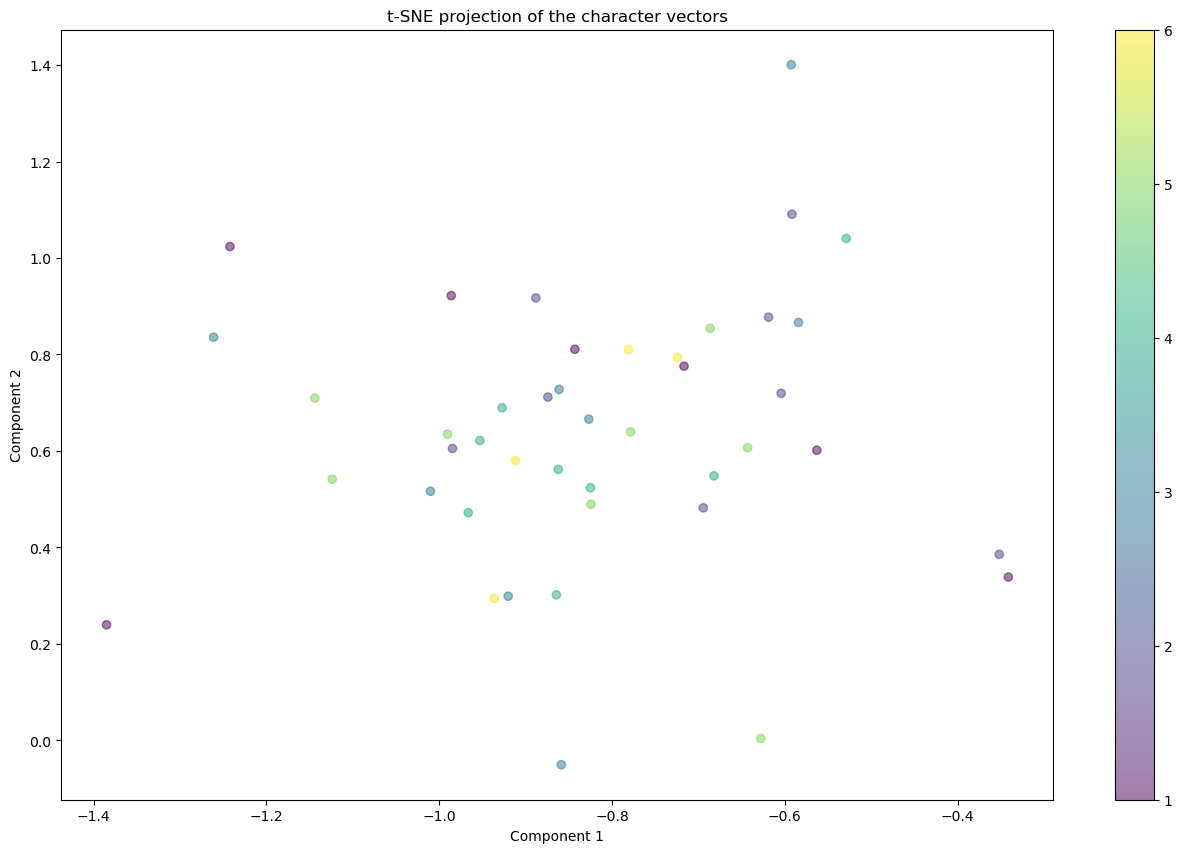

In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Convert string representations of tensors to actual tensors
vector_data = np.loadtxt("vectors.txt")
label_data = np.loadtxt("labels.txt")

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(vector_data)

# Plot the results with labels colored
plt.figure(figsize=(16,10))
scatter = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=label_data, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)
plt.title('t-SNE projection of the character vectors')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()